# Part 4: Feature Importance Analysis

In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
features = pd.read_csv('../data/features_plus_descriptions.csv')
features.set_index('Feature Type and Number', inplace=True)
features.drop(['S5', 'D21'], axis=0, inplace=True)
print('number of features:', len(features.index))

number of features: 51


In [3]:
target = ['H0_Best','H1_Best', 'H2_Best', 'H3_Best', 'H4_Best', 'H5_Best']

df = pd.read_csv('../data/multilabel_with_tol_raw_data.csv')
X = df.loc[:, features.index]
y = df[target]

In [4]:
def split_data(X, y):
    """
    Using the random state multiplier 6 (the best one for the saved best random forest model),
    split the dataset into the test and other sets and return the test sets.
    """
    random_state = 431 * 6 # best random state for random forest saved model
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_state)
    return X_test, y_test

In [5]:
X_test, y_test = split_data(X, y)

In [6]:
file = open('../results/RF_models_micro.pkl', 'rb')
grid = pickle.load(file)
file.close()

In [7]:
best_model = grid[6] # 6 was best random state index

In [8]:
# Check that this is the same as the best score from 3a ML Algos
y_pred = best_model.predict(X_test)
print('f1:', f1_score(y_test, y_pred, average="micro")) 

f1: 0.6958538706871558


## Global Permutation Feature Importance

#### RF Feature Importances 

In [9]:
importances = best_model.best_estimator_.steps[1][1].feature_importances_

In [10]:
imp_argsort = np.argsort(importances)[::-1]

In [11]:
for i in imp_argsort:
    print(features.index[i], importances[i])

D4 0.06520063375031762
D2 0.04412110777583713
S14 0.03816689576538704
D10 0.03628049616092518
D16 0.033677118858108715
D18 0.032696781542750734
D14 0.03224968681506874
D12 0.032083291130422055
S12 0.031651937826337476
S3 0.030348012271285828
S13 0.02858222152238096
S7 0.02852894228653404
D8 0.026976137936571866
D33 0.02638802535716037
D3 0.025904813402093562
D27 0.025626469516202337
D6 0.025499320567351214
D26 0.024937646081762466
D34 0.022502968142300066
D38 0.020621107641689822
S10 0.020169584292672717
S6 0.01916928640322405
D25 0.018527599104809167
S2 0.01782021191341961
S4 0.017730695103600026
D29 0.017475285622097943
D36 0.016573859590668802
D39 0.015794356585422324
D37 0.015618708581732019
S1 0.014631624063986893
S8 0.014579198420106224
D15 0.013332826937918183
D13 0.0133162685646606
D35 0.012183675391387283
D32 0.012082005479449187
D1 0.011631720552907177
D19 0.010465033034100306
D24 0.010308013077029023
S9 0.010203246703673043
S11 0.010123303483414293
D17 0.009666888071454941
D

In [12]:
df_corr = df.corr()
for row in df_corr.index:
    for col in df_corr.columns:
        if row != col and np.abs(df_corr.loc[row, col]) > 0.99:
            print(row, col, ":", df_corr.loc[row, col])
            print(features['Description'].loc[row])
            print(features['Description'].loc[col] + "\n")

D1 D19 : 1.0
Proportion of generated clauses kept (trivial clauses are discarded)
Ratio of the number of non-trivial clauses to |P|

D19 D1 : 1.0
Ratio of the number of non-trivial clauses to |P|
Proportion of generated clauses kept (trivial clauses are discarded)

D20 D31 : 0.9957256059612296
Ratio of the number of other redundant clauses to |P|
resolv count/|P|

D25 D29 : 0.9997931393064408
Ratio of the number of generated clauses to |P|
Ratio of paramodulations to |P|

D29 D25 : 0.9997931393064408
Ratio of paramodulations to |P|
Ratio of the number of generated clauses to |P|

D31 D20 : 0.9957256059612296
resolv count/|P|
Ratio of the number of other redundant clauses to |P|

D32 D35 : 0.99029122385487
Fraction of unit clauses in U
Fraction of demodulator clauses in U

D35 D32 : 0.99029122385487
Fraction of demodulator clauses in U
Fraction of unit clauses in U



In [13]:
pair_dict1 = {'D1': 'D19', 'D25': 'D29', 'D20': 'D31', 'D32': 'D35'}
pair_dict2 = {'D19': 'D1', 'D29': 'D25', 'D31': 'D20', 'D35': 'D32'}

In [14]:
np.random.seed(6)

num_runs = 10
scores = np.zeros([len(features.index), num_runs])
test_score = best_model.score(X_test, y_test)
print('test score: ',test_score)

for i in range(len(features.index)):
    curr_feat = features.index[i]
    paired_feat = ''
    f1_scores = []
    if curr_feat in pair_dict1.keys():
        paired_feat = pair_dict1[curr_feat]
    elif curr_feat in pair_dict2.keys():
        paired_feat = pair_dict2[curr_feat]
    print('shuffling ' + str(curr_feat) + '   ' + paired_feat)
    for j in range(num_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[curr_feat] = np.random.permutation(X_test[curr_feat].values)
        if paired_feat != '':
            X_test_shuffled[paired_feat] = np.random.permutation(X_test[paired_feat].values)
        f1_scores.append(best_model.score(X_test_shuffled, y_test))
    print('   shuffled test score:',np.around(np.mean(f1_scores), 3),'+/-',np.around(np.std(f1_scores), 3))
    scores[i] = f1_scores    

test score:  0.6958538706871558
shuffling S1   
   shuffled test score: 0.694 +/- 0.002
shuffling S2   
   shuffled test score: 0.691 +/- 0.002
shuffling S3   
   shuffled test score: 0.673 +/- 0.003
shuffling S4   
   shuffled test score: 0.692 +/- 0.002
shuffling S6   
   shuffled test score: 0.691 +/- 0.002
shuffling S7   
   shuffled test score: 0.683 +/- 0.001
shuffling S8   
   shuffled test score: 0.694 +/- 0.001
shuffling S9   
   shuffled test score: 0.693 +/- 0.003
shuffling S10   
   shuffled test score: 0.685 +/- 0.002
shuffling S11   
   shuffled test score: 0.691 +/- 0.002
shuffling S12   
   shuffled test score: 0.686 +/- 0.003
shuffling S13   
   shuffled test score: 0.649 +/- 0.005
shuffling S14   
   shuffled test score: 0.677 +/- 0.004
shuffling D1   D19
   shuffled test score: 0.688 +/- 0.003
shuffling D2   
   shuffled test score: 0.687 +/- 0.002
shuffling D3   
   shuffled test score: 0.688 +/- 0.002
shuffling D4   
   shuffled test score: 0.546 +/- 0.006
shufflin

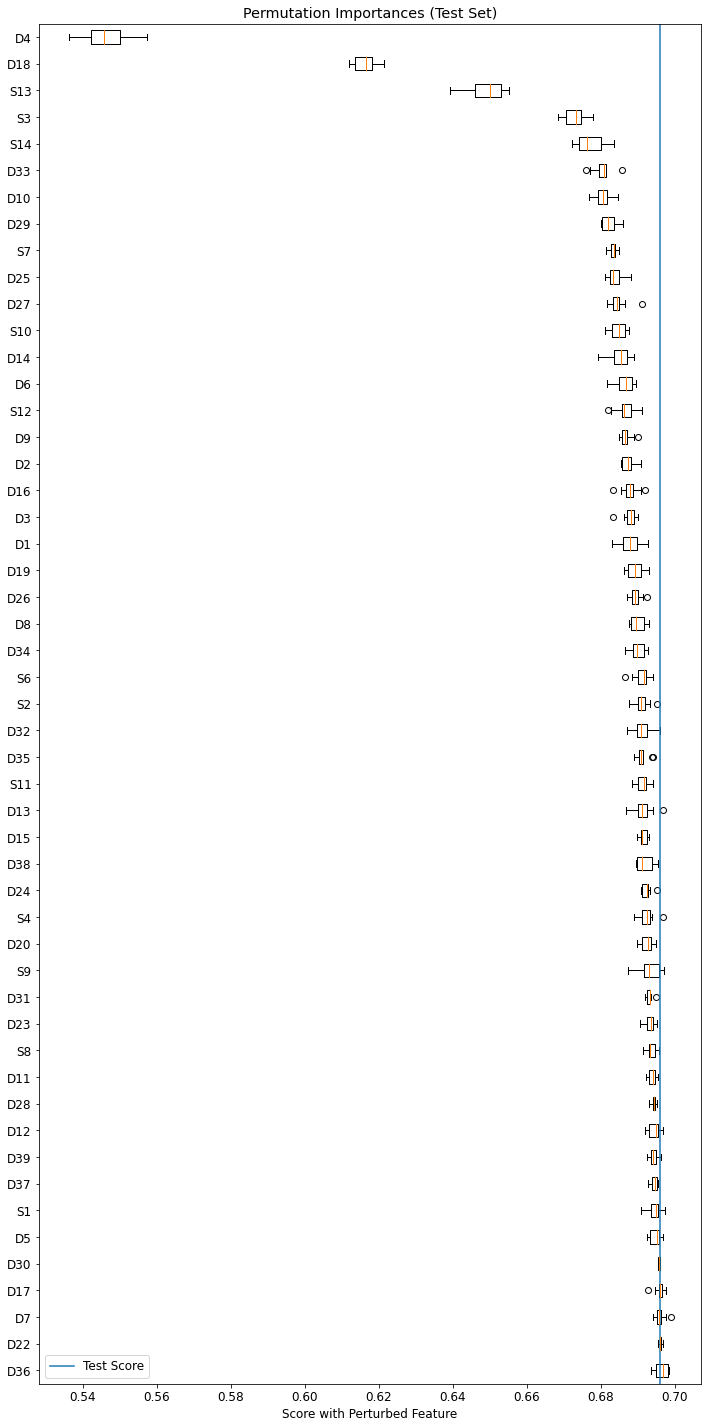

In [15]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,20))
plt.boxplot(scores[sorted_indcs].T, labels=features.index[sorted_indcs], vert=False)
plt.axvline(test_score,label='Test Score')
plt.title("Permutation Importances (Test Set)")
plt.xlabel('Score with Perturbed Feature')
plt.legend()
plt.tight_layout()
plt.show()

## Find Best Estimator and Params

In [16]:
print(best_model.best_estimator_)
print(best_model.best_params_)
# The parameters clf__max_depth and clf__max_features are the ones which gave the best result
# The parameters inside the clf RandomForestClassifier are not the ones that were the best

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('clf', RandomForestClassifier(max_depth=40, max_features=35))])
{'clf': RandomForestClassifier(max_depth=35, max_features=30), 'clf__max_depth': 40, 'clf__max_features': 35}


In [17]:
best_clf = best_model.best_estimator_ 
# Check that this is the right estimator
yp_testing = best_clf.predict(X_test)
print(f1_score(y_test, yp_testing, average="micro"))

0.6958538706871558


## Info from 3a ML Algos file

```
mean test score for Dummy Classifier: 0.3459407160833628
stdev of test score for Dummy Classifier: 0.007281207461362988


6
best test score for Random Forest: 0.6958538706871558
best estimator for Random Forest: {'clf': RandomForestClassifier(max_depth=35, max_features=30), 'clf__max_depth': 40, 'clf__max_features': 35}

mean test score for Random Forest: 0.6824581364808062
stdev of test score for Random Forest: 0.00672101219853508
```

## SHAP

In [18]:
std_scaler = best_clf.steps[0][1]
print(std_scaler)
best_rf_clf = best_clf.steps[1][1]
print(best_rf_clf)

StandardScaler()
RandomForestClassifier(max_depth=40, max_features=35)


In [19]:
X_test_transformed = std_scaler.transform(X_test)

In [20]:
y_test_testing = best_rf_clf.predict(X_test_transformed)
print(f1_score(y_test, y_test_testing, average="micro"))

0.6958538706871558


In [21]:
import shap
shap.initjs()

In [22]:
explainer = shap.TreeExplainer(best_model.best_estimator_[1]) # , feature_perturbation='interventional'

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [23]:
shap_values = explainer.shap_values(X_test_transformed[:1000], check_additivity=False)
print(np.shape(shap_values))

(12, 1000, 51)


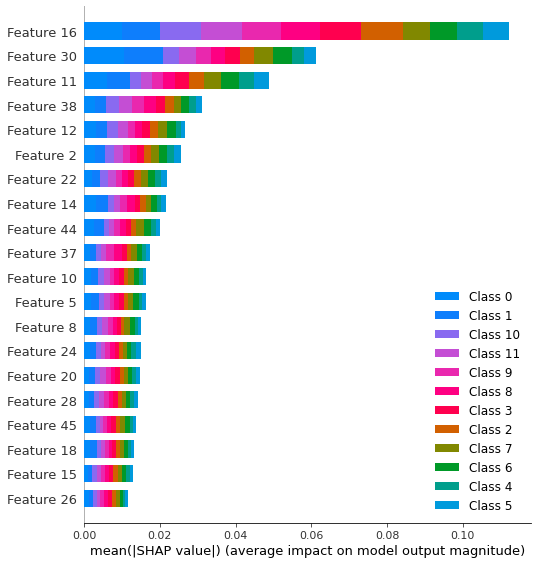

In [28]:
shap.summary_plot(shap_values[:1000], X_test_transformed[:1000], plot_type="bar")

In [45]:
index = 1
print(explainer.expected_value[0]) 
shap.force_plot(explainer.expected_value[0], shap_values[0][index,:], features = features.index)

0.12343413703855062
